# Featuristic: Advanced Feature Engineering Pipeline

This notebook demonstrates an optimized `featuristic` pipeline. We improve the results by:
1. **Increasing Search Resources**: Larger population and more generations for deeper exploration.
2. **Cross-Validated Selection**: Using 5-fold cross-validation in the feature selector to ensure features generalize.
3. **Complexity Control**: Tuning the parsimony coefficient to prevent overfitting.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import featuristic as ft

# Set seed for reproducibility
np.random.seed(42)

In [2]:
ft.__version__

'2.0.0'

## 1. Create a Challenging Dataset

We'll generate a synthetic classification dataset with 20 features to make selection more relevant.

In [3]:
X_raw, y = make_classification(
    n_samples=1000, 
    n_features=20, 
    n_informative=7, 
    n_redundant=4, 
    flip_y=0.1, 
    random_state=42
)

feature_names = [f"feature_{i}" for i in range(20)]
X = pd.DataFrame(X_raw, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")

Training set shape: (800, 20)


## 2. Baseline Model (Raw Features)

Standard Logistic Regression on the original 20 features.

In [4]:
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)
acc_baseline = accuracy_score(y_test, baseline_model.predict(X_test))
print(f"Baseline Accuracy: {acc_baseline:.4f}")

Baseline Accuracy: 0.7850


## 3. Advanced Feature Synthesis

We increase the `population_size` and `generations` to find more powerful features, and lower the `parsimony_coefficient` to allow for slightly more complex expressions.

In [5]:
synth = ft.GeneticFeatureSynthesis(
    n_features=25,
    population_size=250,   
    max_generations=250,        
    parsimony_coefficient=0.001, 
    random_state=42,
)

# Create synthetic features
X_train_synth = synth.fit_transform(X_train, y_train)

# Transform test set
X_test_synth = synth.transform(X_test)

<Axes: title={'center': 'Feature Synthesis Convergence (per Generation)'}, xlabel='Generation', ylabel='Fitness Score'>

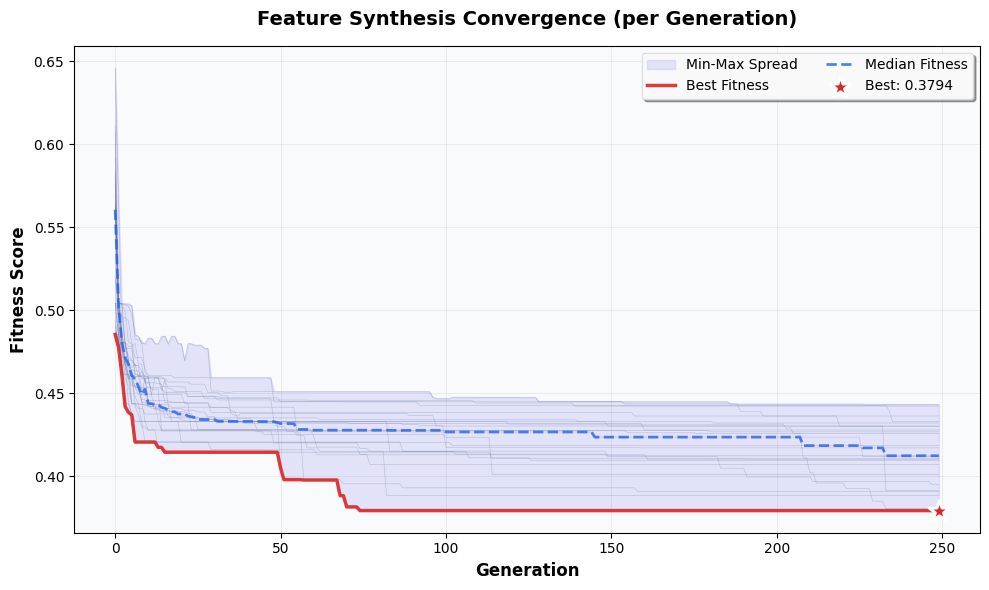

In [6]:
synth.plot_convergence()

In [7]:
for prog in synth.get_programs()[:5]:
    print(prog["formula"])

(((abs(((feature_9 + feature_12) + cos((-0.541568849918062 * feature_8)))) - feature_14) - feature_10) - feature_15)
(0.37444557239587617 * feature_0)
((feature_10 - feature_18) - (-0.5236494277369039 * ((negate(feature_17) + feature_10) - (feature_12 * ((-0.7639395408418199 + feature_14) + feature_9)))))
(feature_10 + (0.7985699235784431 * (negate(((feature_9 * feature_12) - feature_10)) + (sin(feature_14) - feature_18))))
((feature_10 + feature_14) + (0.9899773451367673 + ((feature_10 + (0.11241623535417355 + feature_15)) + negate((feature_9 * feature_12)))))


In [8]:
all_features_model = LogisticRegression(max_iter=1000)
all_features_model.fit(X_train_synth, y_train)
acc_all_features = accuracy_score(y_test, all_features_model.predict(X_test_synth))
print(f"All Features Accuracy: {acc_all_features:.4f}")

All Features Accuracy: 0.8850


## 4. Robust Evolutionary Feature Selection

We optimize the selector by using **5-fold cross-validation** within the objective function. This helps prevent selecting features that only work well on the training split.

In [9]:
# Define a robust objective: minimize negative CV accuracy
def objective(X_subset, y):
    model = LogisticRegression(max_iter=1000)
    # Use cross-validation for a more stable estimate of performance
    scores = cross_val_score(
        model, X_subset, y, cv=3, scoring='neg_log_loss', n_jobs=-1
    )
    return -scores.mean()

selector = ft.GeneticFeatureSelector(
    objective_function=objective, 
    population_size=100,  # Increased for better search
    max_generations=50,    # Increased for better search
    verbose=True, 
    random_state=42
)

X_train_final = selector.fit_transform(X_train_synth, y_train)
X_test_final = selector.transform(X_test_synth)

print(f"X_train_final.shape: {X_train_final.shape}")

Optimising feature selection...:  52%|█████▏    | 26/50 [00:15<00:13,  1.73it/s]

Early termination at iter 26,                           best error:   0.380964
X_train_final.shape: (800, 18)


<Axes: title={'center': 'Feature Selection Convergence'}, xlabel='Generation', ylabel='Objective Score'>

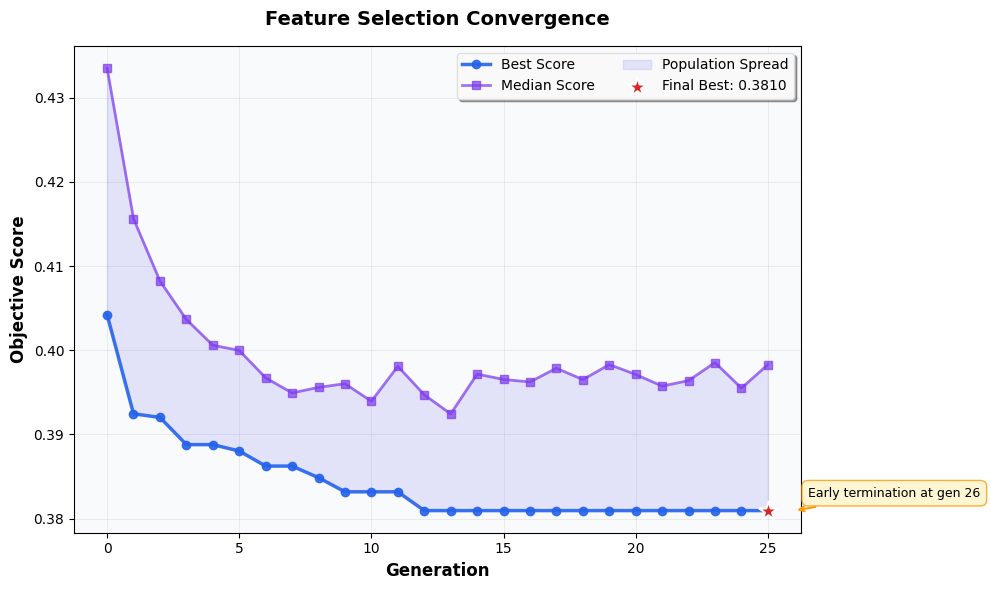

In [10]:
selector.plot_convergence()

## 5. Final Comparison

Compare the baseline with the advanced engineered pipeline.

In [11]:
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train_final, y_train)

y_pred_final = final_model.predict(X_test_final)
acc_final = accuracy_score(y_test, y_pred_final)

print(acc_final)

improvement = (acc_final - acc_baseline) / acc_baseline * 100
print(f"Final Accuracy Improvement: {improvement:.2f}%")

0.89
Final Accuracy Improvement: 13.38%
